In [1]:
import tensorflow as tf
import numpy as np
import math
import glob
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot,savefig
from dataset import *

from sklearn.datasets import load_iris
import xgboost as xgb
import sklearn as sk
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.decomposition import PCA
import mylib as ml2
from mylib import LiftNet, create_LiftNet, create_Standard_LiftNet, Standard_LiftNet, create_Standard_LiftNet_CWRU

from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import pandas as pd
import plotly.figure_factory as ff

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import seaborn as sea

#setting offilne
plotly.offline.init_notebook_mode(connected=True)


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
#------------------------default parameters-----------------------#
test_rate = 0.2
epochs = 1000

lr=0.015
momentum=0.8

decay=0.01

validation_split=0.2
steps_per_epoch=1
validation_steps=1
bunch_steps = 100
snapshot = 500
bunch_steps = 100
snapshot = 500
print('set default parameters')

set default parameters


In [228]:
#------------------------adjustable parameters-----------------------#
model_path = ['/media/silverbullet/data_and_programing_file/newpaper/code/code1226/model/circle_1_to_6_in_our_data/', 
              '/media/silverbullet/data_and_programing_file/newpaper/code/code1226/model/circle_7_to_16_in_our_data_with_0.01_noise_data/',
              '/media/silverbullet/data_and_programing_file/newpaper/code/code1226/model/model_in_CWRU_data/']
model_head_name = ['Standard_LiftingNet_',
                   'Standard_LiftingNet_use_expansion_data__with_',
                   'Standard_expansion_CWRU_data_LiftingNet__with_',
                  'Standard_LiftingNet_use_expansion_data_',
                  'Standard_expansion_CWRU_data_LiftingNet_']

data_path = ['/media/silverbullet/data_and_programing_file/newpaper/dataset/newdataset/','/media/silverbullet/data_and_programing_file/newpaper/dataset/CWRU/CWRUdataset']

class_num = 6
circle_num = 16
cutsize = 256
steps = 600
whether_use_CWRU_data = 1
LiftingNet_noise_scale = 2
whether_expansion_data = 1
expansion_data_number = 500
noise_scales = 0.01
if whether_use_CWRU_data==1:
    noise_scales = LiftingNet_noise_scale

#artificial_feature_method: 1 is 19 features, 2 is 9 features
artificial_feature_method = 2

pca_parameters = 27

if whether_use_CWRU_data == 1:
    cutsize = 1024
    input_shape = (cutsize,2)
    channel = 2
    dataset, label = load_CWRU_data(data_path[1])
    read_model_name = model_path[2]+model_head_name[2]+str(LiftingNet_noise_scale)+'_noise_'+str(cutsize)+'_data_the_'+str(steps)+'th_snapshot_with_'+str(steps_per_epoch)+'_steps_per_epoch.h5'
    if LiftingNet_noise_scale == 0:
        read_model_name = model_path[2]+model_head_name[4]+str(cutsize)+'_data_the_'+str(steps)+'th_snapshot_with_'+str(steps_per_epoch)+'_steps_per_epoch.h5'
else:
    cutsize = 256
    input_shape = (640*circle_num,3)
    channel = 3
    dataset, label = load_dataset(data_path[0], circle_num=circle_num, cutsize=cutsize)
    if circle_num<7:
        read_model_name = model_path[0] + model_head_name[0]+str(circle_num)+'_data_the_'+str(steps)+'th_snapshot_with_'+str(steps_per_epoch)+'_steps_per_epoch.h5'
    else:
        read_model_name = model_path[1] + model_head_name[1]+str(LiftingNet_noise_scale)+'_noise_'+str(circle_num)+'_data_the_'+str(steps)+'th_snapshot_with_'+str(steps_per_epoch)+'_steps_per_epoch.h5'

if circle_num==8:
    read_model_name= model_path[1] + model_head_name[3] +  str(circle_num)+'_data_the_'+str(steps)+'th_snapshot_with_'+str(steps_per_epoch)+'_steps_per_epoch.h5'

print('set adjustable parameters')

dataset shape :  (832, 1024, 2)
label shape :  (832, 1)
set adjustable parameters


In [229]:
#------------------------expansion data parameters-----------------------#

if whether_expansion_data == 1:
    dataset, label = expansion_and_add_noise(dataset,label,exnumber=expansion_data_number, noise_scales=noise_scales)
    print('data expansion')

#------------------------data processing---------------------------------#

input_shape = (dataset.shape[1],dataset.shape[2])
channel = dataset.shape[2]

x_number = dataset.shape[0]

x = dataset
print('x.shape: ',x.shape)
y = label
print('y.shape: ', y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=615)
print('x_train.shape: ', x_train.shape)
print('x_test.shape: ',x_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

x_train_number = x_train.shape[0]
x_test_number = x_test.shape[0]
print('x_train_number: ',x_train_number)
print('x_test_number: ',x_test_number)

(237, 1024, 2)
(118, 1024, 2)
(117, 1024, 2)
(118, 1024, 2)
(118, 1024, 2)
(118, 1024, 2)
(500, 1024, 2)
(500, 1)
(500, 1024, 2)
(500, 1)
(500, 1024, 2)
(500, 1)
(500, 1024, 2)
(500, 1)
(500, 1024, 2)
(500, 1)
(500, 1024, 2)
(500, 1)
(3000, 1024, 2)
(3000, 1)
data_max_abs_x.shape:  (3000, 1, 2)
noise_data.shape:  (3000, 1024, 2)
after expansion: 
dataset shape :  (3832, 1024, 2)
label shape :  (3832, 1)
data expansion
x.shape:  (3832, 1024, 2)
y.shape:  (3832, 1)
x_train.shape:  (3065, 1024, 2)
x_test.shape:  (767, 1024, 2)
y_train.shape:  (3065, 1)
y_test.shape:  (767, 1)
x_train_number:  3065
x_test_number:  767


In [230]:
#------------------------------artificial features extraction-----------------------------#
if artificial_feature_method == 1:
    artificial_feature_data = feature_extractor(dataset)
else:
    artificial_feature_data = feature_extractor2(dataset)
#artificial_feature_data = artificial_feature_data.reshape(x_number,-1)[:,:select_feature_numbers]
artificial_feature_data = artificial_feature_data.reshape(x_number,-1)
print('artificial_feature_data.shape: ', artificial_feature_data.shape)

p1.shape:  (3832, 2)
p2.shape:  (3832, 2)
p3.shape:  (3832, 2)
p4.shape:  (3832, 2)
p5.shape:  (3832, 2)
p6.shape:  (3832, 2)
p7.shape:  (3832, 2)
p8.shape:  (3832, 2)
p9.shape:  (3832, 2)
artificial_feature_data.shape:  (3832, 18)


In [231]:
#--------------------------------load LiftingNet-------------------------------------------#
if whether_use_CWRU_data == 1:
    liftnet = create_Standard_LiftNet_CWRU(class_num = class_num, 
                                       channel = channel, 
                                       cut_size = cutsize, 
                                       input_shape = input_shape,
                                       lr=lr, 
                                       momentum = momentum, 
                                       decay=decay)
else:
    liftnet = create_Standard_LiftNet(class_num = class_num, 
                                  channel = channel, 
                                  circle_num = circle_num, 
                                  input_shape=input_shape,
                                  lr=lr, 
                                  momentum=momentum, 
                                  decay=decay)

liftnet.load_weights(read_model_name)
print('load model')


Model: "LiftNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024, 2)]         0         
_________________________________________________________________
convinputs (Conv1D)          multiple                  6         
_________________________________________________________________
predict1_1 (Conv1D)          multiple                  14        
_________________________________________________________________
predict1_2 (Conv1D)          multiple                  30        
_________________________________________________________________
update1_1 (Conv1D)           multiple                  62        
_________________________________________________________________
update1_2 (Conv1D)           multiple                  30        
_________________________________________________________________
predict2_1 (Conv1D)          multiple                  310 

In [232]:
#----------------------------------LiftingNet features---------------------------------#
print('start extract feature')
feature_data = liftnet.feature_extractor(dataset)
print('extracted feature')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    feature_data = feature_data.eval()
#feature_data = tf.Session().run(feature_data)
#sess = tf.InteractiveSession()
#feature_data = feature_data.eval()
#print(feature_data)
print('feature_data.shape: ', feature_data.shape)
feature_data = np.reshape(feature_data,(feature_data.shape[0],feature_data.shape[1]))
#feature_data = np.concatenate(dataset,axis=2)
print('feature_data.shape: ', feature_data.shape)
print('finished feature extract')
pca_feature_extractor = PCA(n_components=pca_parameters)
pca_feature_extractor.fit(feature_data)
pca_feature = pca_feature_extractor.transform(feature_data)
print('pca_feature.shape: ', pca_feature.shape)


start extract feature
extracted feature
feature_data.shape:  (3832, 250)
feature_data.shape:  (3832, 250)
finished feature extract
pca_feature.shape:  (3832, 27)


In [233]:
#--------------------------create xgboost train dataset---------------------------#
x = pca_feature.reshape(x_number,-1)

#x = feature_data.reshape(x_number,-1)
x = np.concatenate((x,artificial_feature_data),axis=1)
print('x.shape: ',x.shape)

y = label.reshape(x_number,)
print('y.shape: ', y.shape)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=99)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

x.shape:  (3832, 45)
y.shape:  (3832,)
X_train.shape:  (3065, 45)
X_test.shape:  (767, 45)
y_train.shape:  (3065,)
y_test.shape:  (767,)


In [234]:
#---------------------------XGBoost------------------------------#
model = XGBClassifier(learning_rate=0.1,
                        n_estimators=1000,         # 树的个数--1000棵树建立xgboost
                        max_depth=16,               # 树的深度
                        min_child_weight = 1,      # 叶子节点最小权重
                        gamma=0.1,                  # 惩罚项中叶子结点个数前的参数
                        subsample=0.8,             # 随机选择80%样本建立决策树
                        colsample_btree=0.8,       # 随机选择80%特征建立决策树
                        objective='multi:softmax', # 指定损失函数
                        scale_pos_weight=1,        # 解决样本个数不平衡的问题
                        )

model.fit(X_train,y_train)
# 对测试集进行预测
#dtest = xgb.DMatrix(X_test)
#ans = model.predict(dtest)
ans = model.predict(X_test)
print('ans.shape: ', ans.shape)
ml2.evaluate_model2(ans, y_test)
# 计算准确率
cnt1 = 0
cnt2 = 0

for i in range(len(y_test)):
    if ans[i] == y_test[i]:
        cnt1 += 1
    else:
        cnt2 += 1
print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))




ans.shape:  (767,)
normal result:
tp: 144  tn: 1  fp: 2  fn: 620
tp/(tp+tn):  0.993103448275862
tp/(tp+fp):  0.9863013698630136
inner_ring result:
tp: 109  tn: 2  fp: 2  fn: 654
tp/(tp+tn):  0.9819819819819819
tp/(tp+fp):  0.9819819819819819
outer_ring result:
tp: 111  tn: 8  fp: 11  fn: 637
tp/(tp+tn):  0.9327731092436975
tp/(tp+fp):  0.9098360655737705
roller result:
tp: 132  tn: 2  fp: 12  fn: 621
tp/(tp+tn):  0.9850746268656716
tp/(tp+fp):  0.9166666666666666
joint result:
tp: 113  tn: 7  fp: 2  fn: 645
tp/(tp+tn):  0.9416666666666667
tp/(tp+fp):  0.9826086956521739
Accuracy: 95.05 % 


[[144   1   0   0   0   0]
 [  2 109   0   0   0   0]
 [  0   0 111   0   0   8]
 [  0   0   0 132   2   0]
 [  0   0   0   6 113   1]
 [  0   1  11   6   0 120]]


'#-------------------------------plot confusion matrix------------------------#\ncm = confusion_matrix(y_test, ans)\nlabel_name1 = [\'NORMAL\', \'IR\', \'OR\', \'BALL\', \'JOINT\']\nlabel_name2 = [\'NORMAL\', \'BALL\', \'IR\', \'OR_3\', \'OR_6\', \'OR_12\']\n\nif whether_use_CWRU_data == 1:\n    label_name = label_name2\nelse:\n    label_name = label_name1\n\ncm = cm.astype(\'int32\')\n\ncmap = sea.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)\n#f, (ax1,ax2) = plt.subplots(figsize = (10,10),nrows=2)\nf= plt.figure(figsize = (16,9))\nax1 = f.add_subplot(1,1,1)\n\n#sea.heatmap(cm,annot=True,ax= ax1, linewidths=0.05, cmap=\'rainbow\',fmt=\'d\')\nsea.heatmap(cm,annot=True,ax= ax1, linewidths=0.05, cmap=cmap,fmt=\'d\')\nax1.set_title("Confusion Matrix")\nax1.set_xlabel(\'Predict\')\nax1.set_ylabel(\'True\')\nax1.set_xticklabels(label_name)\nax1.set_yticklabels(label_name)\n\n#plot_confusion_matrix(cm, label_name, "Confusion Matrix")\nprint(cm)\nplt.savefig(\'Confusion M

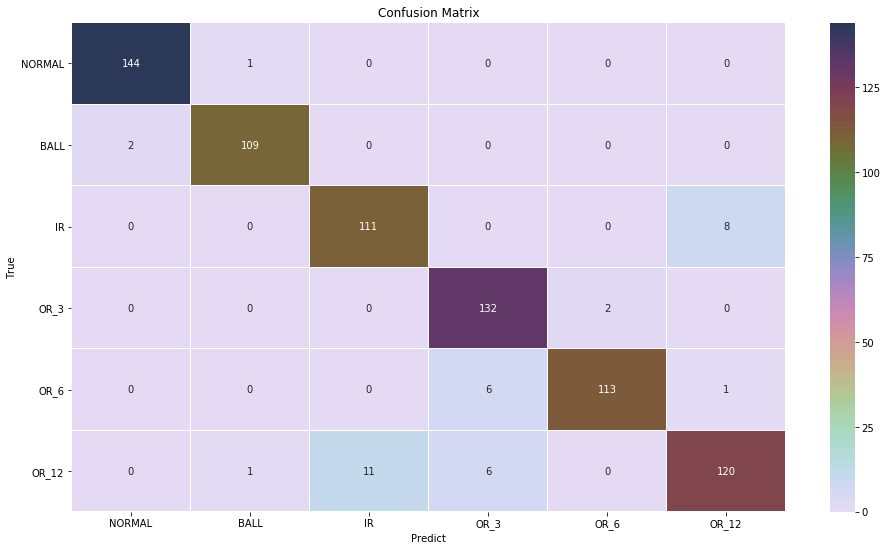

In [235]:
#-------------------------------plot confusion matrix------------------------#

label_name1 = ['NORMAL', 'IR', 'OR', 'BALL', 'JOINT']
label_name2 = ['NORMAL', 'BALL', 'IR', 'OR_3', 'OR_6', 'OR_12']

if whether_use_CWRU_data == 1:
    label_name = label_name2
else:
    label_name = label_name1

save_confusion_path1 = '/media/silverbullet/data_and_programing_file/newpaper/code/code1226/confusion_matrix/ourdata'
save_confusion_path2 = '/media/silverbullet/data_and_programing_file/newpaper/code/code1226/confusion_matrix/CWRUdata'

if whether_use_CWRU_data == 1:
    save_fig_name = save_confusion_path2 + '/CWRU_data_model_in_' + str(LiftingNet_noise_scale) + '_noise_to_test_' + str(noise_scales) + '_noise_scale_data_confusion_matrix.png'
else:
    save_fig_name = save_confusion_path1 + '/Our_data_model_in_' + str(circle_num) + '_circles_model_to_test_' + str(noise_scales) + '_noise_expansion_data_confusion_matrix.png'


plot_confusion_matrix(ans,y_test,label_name, save_name=save_fig_name)


"""#-------------------------------plot confusion matrix------------------------#
cm = confusion_matrix(y_test, ans)
label_name1 = ['NORMAL', 'IR', 'OR', 'BALL', 'JOINT']
label_name2 = ['NORMAL', 'BALL', 'IR', 'OR_3', 'OR_6', 'OR_12']

if whether_use_CWRU_data == 1:
    label_name = label_name2
else:
    label_name = label_name1

cm = cm.astype('int32')

cmap = sea.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
#f, (ax1,ax2) = plt.subplots(figsize = (10,10),nrows=2)
f= plt.figure(figsize = (16,9))
ax1 = f.add_subplot(1,1,1)

#sea.heatmap(cm,annot=True,ax= ax1, linewidths=0.05, cmap='rainbow',fmt='d')
sea.heatmap(cm,annot=True,ax= ax1, linewidths=0.05, cmap=cmap,fmt='d')
ax1.set_title("Confusion Matrix")
ax1.set_xlabel('Predict')
ax1.set_ylabel('True')
ax1.set_xticklabels(label_name)
ax1.set_yticklabels(label_name)

#plot_confusion_matrix(cm, label_name, "Confusion Matrix")
print(cm)
plt.savefig('Confusion Matrix.png', format='png')"""


In [211]:
"""
#---------------------------K Fold-------------------------------------------#
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(model, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
sorted(scores.keys())
print('test result:')
print(scores)
scores_df = pd.DataFrame(scores)

#table_header = ['test_recall_macro', 'train_recall_macro','fit_time', 'train_precision_macro','test_precision_macro']

scores_df

"""

"\n#---------------------------K Fold-------------------------------------------#\nscoring = ['precision_macro', 'recall_macro']\nscores = cross_validate(model, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)\nsorted(scores.keys())\nprint('test result:')\nprint(scores)\nscores_df = pd.DataFrame(scores)\n\n#table_header = ['test_recall_macro', 'train_recall_macro','fit_time', 'train_precision_macro','test_precision_macro']\n\nscores_df\n\n"